Author: Steven Vuong <br>
Last Edited: 25/05/2020

Here we pick off where we left off with the last preprocessing notebook. We have our processed raw tweets and want to apply another processing step. Firstly, we must open our processed data first.

Note: Later on this wa modified for usage with Google Colab. Approached this because of a lack of GPUs

In [1]:
# TODO: modularisse and put funcs in python files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
csv_savepath = 'tweets_processed.csv' #"../../data/tweets_processed.pkl"
tweets_df = pd.read_csv(csv_savepath) 

We will drop the hashtags column as we have used this to create our predictive labels. It is possiblle that other features from this may be used to help predict other hashtags. For the time being, however, we will not consider it so. <br>
In addition, we will drop our original tweet_text column as we have the processed form of it.

In [3]:
tweets_df = tweets_df.drop(['tweet_text', 'tweet_hashtags'], axis=1)
tweets_df.head()

,Unnamed: 0,tweet_creation_date,tweet_retweet_count,tweet_favourite_count,user_follow_count,user_created_at,user_verified,processed_tweets,covid_hashtag
0,0,2020-05-17 14:36:25,111,0,32,2018-09-17 22:49:14,False,rt @jdfarag sun enter ‘lockdown’ period could ...,False
1,1,2020-05-17 14:27:49,0,0,974,2016-06-28 19:39:16,False,kenya pastoralists face hunger conflict locust...,False
2,2,2020-05-17 14:21:52,36,0,27,2010-05-29 12:41:00,False,rt @drvandanashiva essentialcommoditiesact use...,False
3,3,2020-05-17 14:15:25,0,0,836,2009-03-27 01:52:54,False,man could literally hunger entire world choose...,False
4,4,2020-05-17 14:14:25,7,0,375,2014-07-04 16:19:51,False,rt presidential april year president express c...,False


In theory, we could use the date as a feature to consider. However, the tweets we have scraped ranges from a short time period.

In [0]:
# convert to datetime
tweets_df['tweet_creation_date'] = pd.to_datetime(tweets_df['tweet_creation_date'])
tweets_df['user_created_at'] = pd.to_datetime(tweets_df['user_created_at'])

In [5]:
earliest_tweet_time = tweets_df['tweet_creation_date'].min()
latest_tweet_time = tweets_df['tweet_creation_date'].max()

print(f"Earliest Tweet Scraped was at {earliest_tweet_time}")
print(f"Latest Tweet Scraped was at {latest_tweet_time}")

Earliest Tweet Scraped was at 2020-05-14 04:39:47
Latest Tweet Scraped was at 2020-05-17 14:36:25


We see the time difference is only 10 hours. Potentially we could make a column of 'hour_tweeted' out of it. However this does not cover all potential hours and there is not enough data. So we will make the decision to drop this column.

In [0]:
tweets_df = tweets_df.drop('tweet_creation_date', axis=1)

Look at user creation date now.

In [7]:
earliest_user_creation_timestamp = tweets_df['user_created_at'].min()
latest_user_creation_timestamp = tweets_df['user_created_at'].max()

print(f"Earliest User Created at {earliest_user_creation_timestamp}")
print(f"Latest User Created at {latest_user_creation_timestamp}")

Earliest User Created at 2007-05-11 08:38:01
Latest User Created at 2020-05-16 23:00:12


Quite a wide range. From 2007 all the way up until the day before scraping. Let's see if we can visualise this.

In [8]:
# first cast a column of ones (will use for counting)
tweets_df['dummy_ones'] = np.ones(len(tweets_df))

# make column for user created month/year/day_of_week/hour
tweets_df['user_created_year'] = tweets_df['user_created_at'].map(lambda x: x.year)
tweets_df['user_created_month'] = tweets_df['user_created_at'].map(lambda x: x.month)
tweets_df['user_created_day_of_week'] = tweets_df['user_created_at'].map(lambda x: x.dayofweek)
tweets_df['user_created_hour'] = tweets_df['user_created_at'].map(lambda x: x.hour)

tweets_df.head()

,Unnamed: 0,tweet_retweet_count,tweet_favourite_count,user_follow_count,user_created_at,user_verified,processed_tweets,covid_hashtag,dummy_ones,user_created_year,user_created_month,user_created_day_of_week,user_created_hour
0,0,111,0,32,2018-09-17 22:49:14,False,rt @jdfarag sun enter ‘lockdown’ period could ...,False,1.0,2018,9,0,22
1,1,0,0,974,2016-06-28 19:39:16,False,kenya pastoralists face hunger conflict locust...,False,1.0,2016,6,1,19
2,2,36,0,27,2010-05-29 12:41:00,False,rt @drvandanashiva essentialcommoditiesact use...,False,1.0,2010,5,5,12
3,3,0,0,836,2009-03-27 01:52:54,False,man could literally hunger entire world choose...,False,1.0,2009,3,4,1
4,4,7,0,375,2014-07-04 16:19:51,False,rt presidential april year president express c...,False,1.0,2014,7,4,16


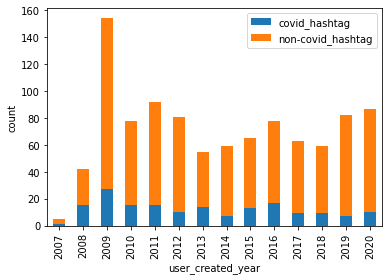

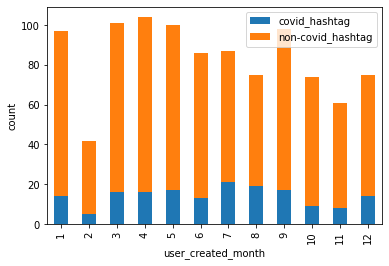

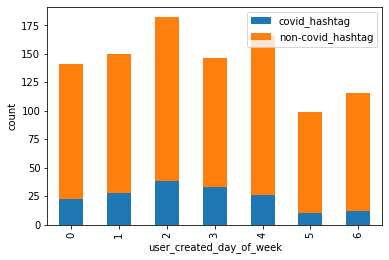

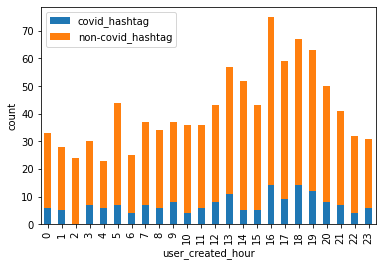

In [9]:
def barplot_groupby_labels_count(
    dataframe: pd.DataFrame, 
    groupby_category: str, 
    count_column: str,
    label_column:str
    ):
    
    groupby_year = dataframe.groupby(groupby_category)[count_column].sum()
    groupby_label = dataframe.groupby(groupby_category)[label_column].sum() # num true

    groupby_df = pd.DataFrame([groupby_year, groupby_label]).T
    groupby_df[f'non-{label_column}'] = groupby_df[count_column] - groupby_df[label_column]

    groupby_df[[label_column, f'non-{label_column}',]].plot(kind='bar', stacked=True)
    plt.ylabel('count')
    plt.show()
    

group_by_categories = ['user_created_year', 'user_created_month', 'user_created_day_of_week', 'user_created_hour']

for category in group_by_categories:
    barplot_groupby_labels_count(tweets_df, category, 'dummy_ones', 'covid_hashtag')
    

Seems there is not much visible correlation between covid hashtag and when the user account was created. Nonetheless, we have engineered some columns and it may come in handly later for modelling, albeit unlikely but could be worth investigation. So drop original user created datetime column and proceed with processing the original tweets.

In [0]:
tweets_df = tweets_df.drop(['dummy_ones', 'user_created_at'], axis=1)

We want to remove frequent and rare words from our processed tweets. First we should take a look at what words are frequent/rare to see what portion we may want to skim off.

Ref:
-  https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing#Removal-of-Frequent-words

In [11]:
from collections import Counter
cnt = Counter()

for text in tweets_df["processed_tweets"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('rt', 543),
 ('hunger', 485),
 ('could', 148),
 ('food', 146),
 ('covid19', 135),
 ('cause', 125),
 ('@jdfarag', 118),
 ('famine', 118),
 ('he', 114),
 ('sun', 109)]

Seems like the most common words are very important. We will keep these

In [12]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])

RAREWORDS

{'african-american',
 'ahumaudarbery',
 'communitymatters',
 'httpstcobwhl7ldhct',
 'httpstcoinkecbg2dh',
 'id',
 'may2020',
 'nov',
 'shooter',
 'w'}

Seem not so relevant. We will remove these rarewords.

In [0]:
def remove_rarewords(text:str, RAREWORDS:set):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

tweets_df['processed_tweets'] = tweets_df['processed_tweets'].apply(lambda x: remove_rarewords(x, RAREWORDS))

In [14]:
tweets_df.head()

,Unnamed: 0,tweet_retweet_count,tweet_favourite_count,user_follow_count,user_verified,processed_tweets,covid_hashtag,user_created_year,user_created_month,user_created_day_of_week,user_created_hour
0,0,111,0,32,False,rt @jdfarag sun enter ‘lockdown’ period could ...,False,2018,9,0,22
1,1,0,0,974,False,kenya pastoralists face hunger conflict locust...,False,2016,6,1,19
2,2,36,0,27,False,rt @drvandanashiva essentialcommoditiesact use...,False,2010,5,5,12
3,3,0,0,836,False,man could literally hunger entire world choose...,False,2009,3,4,1
4,4,7,0,375,False,rt presidential april year president express c...,False,2014,7,4,16


So part of the preprocessing is done. We still need to label encode features and perhaps normalise the retweet_count, tweet_favourite_count and user_follow_count. 

First, we plot a heat correlation map of our dataframe. Later on we may be ensembling other models in addition to our one for text data only to include other features from our dataset.

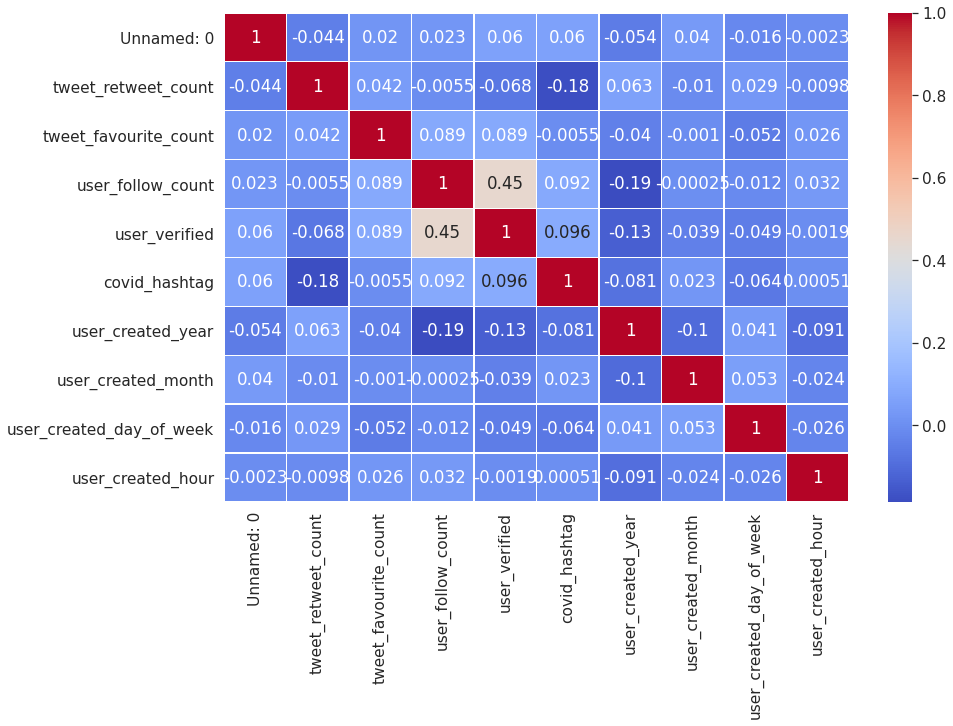

In [15]:
sns.set(font_scale=1.4)
plt.figure(figsize = (14,9))
sns.heatmap(tweets_df.corr(), cmap='coolwarm', annot=True, linewidths=.5)
plt.show()

Next step: Normalise numerical columns.

Ref: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

In [16]:
def normalise_column(dataframe: pd.DataFrame, column_name: str):
    col = dataframe[column_name]
    dataframe[column_name] = (col - col.min()) / (col.max() - col.min())
    return dataframe
    
numerical_columns = ['tweet_retweet_count', 'tweet_favourite_count', 'user_follow_count']                               

for numerical_column in numerical_columns:
    normalise_column(tweets_df, numerical_column)

tweets_df.head()

,Unnamed: 0,tweet_retweet_count,tweet_favourite_count,user_follow_count,user_verified,processed_tweets,covid_hashtag,user_created_year,user_created_month,user_created_day_of_week,user_created_hour
0,0,0.299191,0.0,0.000086,False,rt @jdfarag sun enter ‘lockdown’ period could ...,False,2018,9,0,22
1,1,0.000000,0.0,0.002624,False,kenya pastoralists face hunger conflict locust...,False,2016,6,1,19
2,2,0.097035,0.0,0.000073,False,rt @drvandanashiva essentialcommoditiesact use...,False,2010,5,5,12
3,3,0.000000,0.0,0.002252,False,man could literally hunger entire world choose...,False,2009,3,4,1
4,4,0.018868,0.0,0.001010,False,rt presidential april year president express c...,False,2014,7,4,16


From here: we will be following https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle to get us into NLP and have an idea of what is possible. In the next notebook perhaps we will try BERT / ALBERT model.


Now: we label encode categorical values

In [17]:
 from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

tweets_df['user_verified'] = label_encoder.fit_transform(tweets_df['user_verified'])
tweets_df['covid_hashtag'] = label_encoder.fit_transform(tweets_df['covid_hashtag'])
tweets_df['user_created_year'] = label_encoder.fit_transform(tweets_df['user_created_year'])

tweets_df.head()

,Unnamed: 0,tweet_retweet_count,tweet_favourite_count,user_follow_count,user_verified,processed_tweets,covid_hashtag,user_created_year,user_created_month,user_created_day_of_week,user_created_hour
0,0,0.299191,0.0,0.000086,0,rt @jdfarag sun enter ‘lockdown’ period could ...,0,11,9,0,22
1,1,0.000000,0.0,0.002624,0,kenya pastoralists face hunger conflict locust...,0,9,6,1,19
2,2,0.097035,0.0,0.000073,0,rt @drvandanashiva essentialcommoditiesact use...,0,3,5,5,12
3,3,0.000000,0.0,0.002252,0,man could literally hunger entire world choose...,0,2,3,4,1
4,4,0.018868,0.0,0.001010,0,rt presidential april year president express c...,0,7,7,4,16


Now we can split into train and test datasets.

In [0]:
train_text = tweets_df['processed_tweets'].values
y = tweets_df['covid_hashtag'].values

In [80]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(train_text, 
                                                  y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, 
                                                  shuffle=True)

print(f"num of train samples: {xtrain.shape}")
print(f"num of test samples: {xvalid.shape}")

num of train samples: (900,)
num of test samples: (100,)


Simple first approach: TF-IDF (Term Frequency - Inverse Document Frequency) followed by simple Logistic Regression.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [0]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota


In [25]:
from sklearn.linear_model import LogisticRegression
# Fit simple Logistic Regression
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print(f"Logistic Regression LogLoss on TFIDF: {multiclass_logloss(yvalid, predictions)}")


Logistic Regression LogLoss on TFIDF: 0.23758946194001015


In [26]:
# binary cross-entropy loss. Default for binary classification
from sklearn.metrics import log_loss
log_loss(yvalid, predictions)

0.23758946194001018

Try CountVectoriser. This uses word counts as features.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

ctv = CountVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [28]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("Logistic Regression logloss on CountVectoriser: %0.3f " % multiclass_logloss(yvalid, predictions))

Logistic Regression logloss on CountVectoriser: 0.112 


Results are much better here.

In [29]:
from sklearn.naive_bayes import MultinomialNB

# Fit Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("Naive Bayes logloss on TFIDF: %0.3f " % multiclass_logloss(yvalid, predictions))

Naive Bayes logloss on TFIDF: 0.261 


In [30]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("Naive Bayes logloss on CountVectoriser: %0.3f " % multiclass_logloss(yvalid, predictions))

Naive Bayes logloss on CountVectoriser: 3.437 


Seems like Naive Bayes for our use case does not seem as great than Logistic Regression.

Next step is to try SVMs. These can take a lot of time so it may be advisable to reduce the number of features from TF-IDF using Singular Value Decomposition (SVD) before applying this.

Also, before applying SVMs, we must standardise the data.


In [0]:
from sklearn import decomposition, preprocessing
from sklearn.decomposition import TruncatedSVD

# TODO: Look into SVD

# Apply SVD. Typically ~120-200 components are good enough for SVD
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# scale data from SVD. Rename variable to use without scaling
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)


In [32]:
from sklearn.svm import SVC
# apply SVM here. This can take a while
clf = SVC(C=1.0, probability=True) # try for probabilities here
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("SVM logloss: %0.3f " % multiclass_logloss(yvalid, predictions))


SVM logloss: 0.081 


Wow. Accuracy is pretty astounding here. Logloss is 0.083.

We can look into another very popular algorithm; XGBoost.

In [33]:
import xgboost as xgb
# fit simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7,
                       n_estimators=200,
                       colsample_bytree=0.8,
                       subsample=0.8,
                       nthread=10,
                       learning_rate=0.1)

clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("XGBoost logloss for TFIDF: %0.3f " % multiclass_logloss(yvalid, predictions))


XGBoost logloss for TFIDF: 0.059 


Even better than SVM, wow.. Lets try on CountVectoriser.

In [34]:
# fit xgboost on countvectoriser
clf = xgb.XGBClassifier(max_depth=7,
                       n_estimators=200,
                       colsample_bytree=0.8,
                       subsample=0.8,
                       nthread=10,
                       learning_rate=0.1)

clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_ctv.tocsc())

print ("XGBoost logloss for CountVectoriser: %0.3f " % multiclass_logloss(yvalid, predictions))


XGBoost logloss for CountVectoriser: 0.051 


Same results for CountVectoriser and TFIDF. A big limitation here might be the size of our dataset, only 1000 values. Perhaps we could have more and see how this works.

In [35]:
# fit xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7,
                       n_estimators=200,
                       colsample_bytree=0.8,
                       subsample=0.8,
                       nthread=10,
                       learning_rate=0.1)

clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("XGBoost logloss for SVD features: %0.3f " % multiclass_logloss(yvalid, predictions))


XGBoost logloss for SVD features: 0.054 


Slightly worse with SVD features. For our use case, XGBoost worked quite well.

### Grid Search
Will implement grid search using logistic regression.

In [0]:
from sklearn import metrics
# need to create a scoring function first. Use 'make_scorer'
mll_scorer = metrics.make_scorer(multiclass_logloss, 
                                 greater_is_better=False, 
                                 needs_proba=True)

Require a pipeline, consisting of SVD scaling then Logistic Regression.

In [0]:
from sklearn import pipeline

# Initialise SVD
svd = TruncatedSVD()

# Initialise standard scaler
scl = preprocessing.StandardScaler()

# Use Log Regression Here
lr_model = LogisticRegression()

# Create pipeline
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

Require a grid of parameters.

In [0]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

For SVD, we evaluate 120 and 180 components and for Logistic Regression, we evaluate 3 different values of C with l1 and l2 penalty. Can start grid search with these parameters.

In [0]:
from sklearn.model_selection import GridSearchCV
# Initialise Grid Search Model
model = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring=mll_scorer,
                    verbose=10,
                    n_jobs=-1,
                    iid=True,
                    refit=True,
                    cv=2)


# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain) # can also use full data

# doesn't seem to work. May be something up with dataset?

print("Best score: %0.3f" % model.best_score_)
best_parameters = model.best_estimator_.get_params()

for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

The above crashes my gridsearch, so will discontinue with gridsearch.

### Word Vectors

How to create sentence vectors and how we can use these to create a machinee learning model on top of it. Abishek Thakur recommends:
-  GloVe vectors
-  word2vec
-  fasttext


We will use GloVe vector in this instance. Can be downloaded from: http://www-nlp.stanford.edu/data/glove.840B.300d.zip

In [45]:
# Download GloVe (required for later on text embedding) and unzip
!wget http://www-nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2020-05-25 13:13:16--  http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Resolving www-nlp.stanford.edu (www-nlp.stanford.edu)... 171.64.67.140
Connecting to www-nlp.stanford.edu (www-nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-05-25 13:13:16--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-05-25 13:13:17--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP r

In [47]:
from tqdm import tqdm
# load GloVe vectors in a directory
embeddings_index = {}
non_appendable_words = []
f = open('glove.840B.300d.txt')
for line in tqdm(f):
    try:
        values = line.split()
        word = values[0].strip()
        coefs = np.asarray(values[1::], dtype='float32')
        embeddings_index[word] = coefs
    except Exception:
        non_appendable_words.append(word)
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(f"Could not append {len(set(non_appendable_words))} words:")
print(set(non_appendable_words))

2196017it [03:13, 11354.79it/s]

Found 2195884 word vectors.
Could not append 15 words:
{'Email', 'email', 'or', 'to', 'Contact', '•', 'on', 'at', 'contact', 'emailing', '.', 'is', 'by', 'in', 'At'}


In [49]:
import nltk
nltk.download('stopwords')

from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
# create normalised vector for the whole sentence
def sent2vec(s, embedding_index):
    """Create normalised vector for a whole sentence.
    :param s:
    :param embedding_index:
    :return normalised_vector:
    """
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stopwords]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embedding_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v**2).sum())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [50]:
import nltk
nltk.download('punkt')

# create sentence vectorss using the above for train and val
xtrain_glove = [sent2vec(x, embeddings_index) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x, embeddings_index) for x in tqdm(xvalid)]

xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 100/100 [00:00<00:00, 3452.02it/s]


See performance of XGBoost glove features.

In [51]:
# fit simple xgboost on glove features

clf = xgb.XGBClassifier(max_depth=7,
                       n_estimators=200,
                       colsample_bytree=0.8,
                       subsample=0.8,
                       nthread=10,
                       learning_rate=0.1)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("XGBoost on Glove features logloss: %0.3f " % multiclass_logloss(yvalid, predictions))


XGBoost on Glove features logloss: 0.329 


Seems that GloVe for this use case has not beared too much fruit. Was cool to learn anyway. We can also use it in trying a Deep Learning Solution.

### Deep Learning

Can play with parameters to be much more powerful.

In [0]:
# scale the data before neural net. Use same scaler for valid as for train
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [0]:
from keras.utils import np_utils
# Must turn labels to binary for neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

# simple 3 layer sequential NN
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [102]:
# train our model
model.fit(xtrain_glove_scl,
          y=ytrain_enc,
          batch_size=64,
          epochs=10,
          verbose=0,
          validation_data=(xvalid_glove_scl, yvalid_enc))

In [103]:
dnn_prerdictions=model.predict(xvalid_glove_scl)

print ("DNN model predictions: %0.3f " % multiclass_logloss(yvalid, dnn_prerdictions))


DNN model predictions: 0.240 


Could do a lot of tuning, tweaking etc.. to improve and get better results. We will move on with LSTM now, this requires tokenisation of data.

In [0]:
# TODO: Look at why we need to tokenise for LSTM
from keras.preprocessing import sequence, text
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [108]:
# TODO: Look into embedding matrix
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 2921/2921 [00:00<00:00, 175813.47it/s]


In [0]:
# TODO: Look into spatial dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import SpatialDropout1D

# A simple LSTM with glove embeddings and two dense layerss
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [115]:
model.fit(xtrain_pad, 
          y=ytrain_enc, 
          batch_size=512, 
          epochs=100, 
          verbose=0, 
          validation_data=(xvalid_pad, yvalid_enc))

In [118]:
lstm_prerdictions=model.predict(xvalid_pad)

print ("LSTM model Loss: %0.3f " % multiclass_logloss(yvalid_enc, lstm_prerdictions))


LSTM model predictions: 0.577 


The currrent loss is above 0.5 . Perhaps we can reduce overfitting with early stopping.

In [121]:
from keras.callbacks import EarlyStopping

# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=0, 
                          mode='auto')
model.fit(xtrain_pad, 
          y=ytrain_enc, 
          batch_size=512, 
          epochs=100, 
          verbose=0, 
          validation_data=(xvalid_pad, yvalid_enc), 
          callbacks=[earlystop])

In [122]:
lstm_prerdictions=model.predict(xvalid_pad)

print ("Earlystopping LSTM model Loss: %0.3f " % multiclass_logloss(yvalid_enc, lstm_prerdictions))


Earlystopping LSTM model predictions: 0.475 


Slightly better but unlikely where we want to be.. Maybe this requires more data for a DNN to work well. For the sake of having examples, we will continue.

In [126]:
# TODO: Look into bidirectional LSTM
from keras.layers import Bidirectional

# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3,
                          verbose=0, 
                          mode='auto')
model.fit(xtrain_pad, 
          y=ytrain_enc, 
          batch_size=512, 
          epochs=100, 
          verbose=0, 
          validation_data=(xvalid_pad, yvalid_enc), 
          callbacks=[earlystop])

In [127]:
lstm_prerdictions=model.predict(xvalid_pad)

print ("Earlystopping Bidirectional LSTM model Loss: %0.3f " % multiclass_logloss(yvalid_enc, lstm_prerdictions))


Earlystopping Bidirectional LSTM model Loss: 0.459 


In [129]:
# TODO: Look into GRU
from keras.layers.recurrent import GRU

# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=0, 
                          mode='auto')
model.fit(xtrain_pad, 
          y=ytrain_enc, 
          batch_size=512, 
          epochs=100, 
          verbose=0, 
          validation_data=(xvalid_pad, yvalid_enc), 
          callbacks=[earlystop])

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 2s 3ms/step - loss: 0.8092 - val_loss: 0.4538
Epoch 2/100
900/900 [==============================] - 1s 1ms/step - loss: 0.6608 - val_loss: 0.4866
Epoch 3/100
900/900 [==============================] - 1s 1ms/step - loss: 0.5588 - val_loss: 0.5600
Epoch 4/100
900/900 [==============================] - 1s 1ms/step - loss: 0.5121 - val_loss: 0.6216


In [130]:
gru_prerdictions=model.predict(xvalid_pad)

print ("GRU model Loss: %0.3f " % multiclass_logloss(yvalid_enc, gru_prerdictions))


GRU model Loss: 0.622 


Soooo not so good in this instance. Still, has given us lots that we can learn.

### Ensembling